# Spectral Theory
---
**Name:** Jonh Alexis Buot <br>
**Date:** December 2023 <br>
**Course:** CS3101N <br>
**Task:** Assignment - Spectral Theory

---

# Assignment 1

Perform `Spectral Clustering` on any given dataset, and derive conclusions from the results.

In [81]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_kernels
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##  Introduction

Malware analysis plays a pivotal role in enhancing cybersecurity. It serves as a defense mechanism in identifying new and emerging threats, allowing for the development, implementation, and execution of effective detection and preventive strategies. In terms of security incidents, insights gained from malware analysis are crucial for understanding the scope and impact of an attack, enabling security teams to mount timely and effective responses. Malware analysis is then crucial for cybersecurity professionals as it keeps them stay abreast of evolving threats and vulnerabilities.


### Clustering Programs (and Malware) with API calls

Application Programming Interface (API) call sequences are fundamental in every program, as they allow programs to access external services in order to perform a certain task (e.g., calling `malloc` to reserve a memory region). API call sequences are also essential in comprehending the bahavior of malware, as malware utilize API calls to perform malicious behavior on the host computer. This means that given a set of call sequences, we could potentially cluster malware and goodware based on their call sequences.

### Dataset

The dataset used was retrieved from [Kaggle](https://www.kaggle.com/) named [Malware Analysis Datasets: API Call Sequences](https://www.kaggle.com/datasets/ang3loliveira/malware-analysis-datasets-api-call-sequences). It contains `42,797 malware API call sequences` and `1,079 goodware API call sequences`. Each API call sequence is composed of the first 100 non-repeated consecutive API calls associated with the parent process, extracted from the 'calls' elements of Cuckoo Sandbox reports.

**Column Descriptions**

| Column name | Description                          | Type                   |
|-------------|--------------------------------------|------------------------|
| hash        | MD5 hash of the example              | 32 bytes string        |
| t_0 ... t_99| API call                             | Integer (0-306)        |
| malware     | Class                                | Integer: 0 (Goodware) or 1 (Malware) |

### Limitations

Only a portion of the complete dataset (non-duplicate, and non-null containing rows removed) are utilized. This is because of hardware limitations, since utilizing the entire dataset takes too long on my machine. The resulting data would then be composed of 20% of the original dataset's `malware` labeled rows only, and these rows are picked randomly.

### Goal

Perform `Spectral Clustering` to uncover inherent structures within the malware dataset based on API call sequences.

In [77]:
data = pd.read_csv("./Spectral_Theory_Data/dynamic_api_call_sequence_per_malware_100_0_306.csv")
data.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


In [78]:
complete_data = data.dropna()
deduped_data = data.drop_duplicates()

# Randomly sample dataset to use only 20% of the dataset
malware_data = deduped_data[deduped_data["malware"] == 1]
sampled_data = malware_data.sample(frac=0.2)

malware_features = sampled_data.iloc[:, 1:101]
malware_features.head()

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
3362,112,274,158,215,274,158,215,298,76,208,...,117,71,297,135,171,215,35,208,56,71
15338,82,208,187,208,172,117,172,117,172,117,...,117,60,81,60,81,60,81,35,215,274
10093,82,240,117,240,117,240,117,240,117,172,...,141,260,141,260,141,260,141,260,141,260
37813,16,172,89,208,108,82,198,286,172,117,...,297,135,171,215,178,148,109,148,208,297
35940,240,117,240,117,240,117,240,117,240,117,...,117,240,117,240,117,240,117,15,117,15


In [79]:
pipe = Pipeline([("scaler", MaxAbsScaler()), ("pca", PCA(n_components = 2))])
processed_features = pipe.fit_transform(malware_features)

affinity_matrix = pairwise_kernels(processed_features, metric="laplacian", n_jobs=-1)

# Compute Spectral Clustering on various cluster sizes
# Tried using ThreadPoolExecutor to parallelize computations, no effect
clustering_results = []
for n_clusters in range(2, 8):
    sc_model = SpectralClustering(n_clusters=n_clusters, n_jobs=-1, affinity="precomputed", eigen_solver="arpack")
    cluster_labels = sc_model.fit_predict(affinity_matrix)

    silhouette_avg = silhouette_score(processed_features, cluster_labels) 
    clustering_results.append([n_clusters, silhouette_avg, cluster_labels])

# Get the cluster with the highest silhouette score
best_cluster = max(clustering_results, key=lambda res : res[1]) 
sampled_data["cluster"] = best_cluster[2]

scores = pd.DataFrame([res[:-1] for res in clustering_results], columns=["Clusters", "Silhouette Scores"])
scores.head()

,Clusters,Silhouette Scores
0,2,0.520347
1,3,0.625125
2,4,0.477025
3,5,0.503712
4,6,0.516364


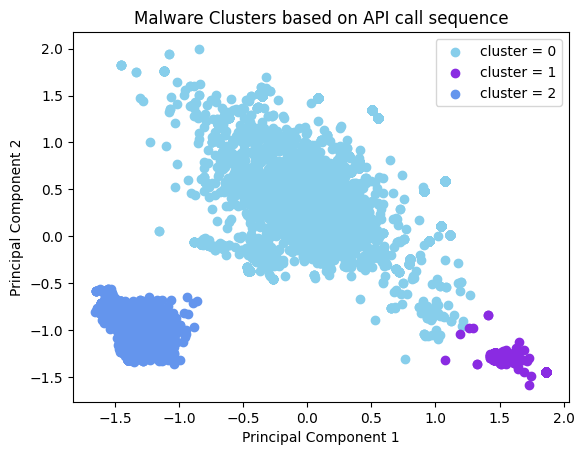

In [80]:
pca_sampled_data = sampled_data[["hash", "cluster"]].copy()

for i in range(processed_features.shape[1]):
    pca_sampled_data[f"PC{i+1}"] = processed_features[:, i]

colorlist =["skyblue", "blueviolet", "cornflowerblue"]
for cluster in range(pca_sampled_data["cluster"].max() + 1):
    cluster_data = pca_sampled_data[pca_sampled_data["cluster"] == cluster]
    plt.scatter(cluster_data["PC1"], cluster_data["PC2"], c = colorlist[cluster], label=f"cluster = {cluster}")

plt.title("Malware Clusters based on API call sequence")
plt.legend(loc="upper right")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Conclusion

In my analysis of the malware dataset using spectral clustering, it was observed that the API call sequences naturally segregate into three distinct clusters. The choice of three clusters maximizes the silhouette score, indicating meaningful separation between the identified groups. This finding suggests that the malware samples exhibit inherent structure, possibly representing different types or families of malware with distinct API call sequences. The use of spectral clustering provides a valuable means of uncovering these underlying patterns in the dataset. To further uncover relationships between the malwares, it is suggested that further analysis is done on the clustered groups with regards to the APIs being called, as well as the sequence that these APIs are called for each malware entry.

# Eigenvector Centrality Assignment

Given the graph below, find its eigenvector centrality.

In [87]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

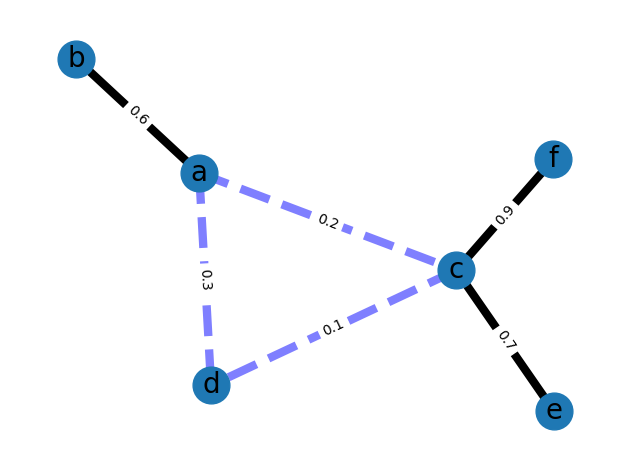

In [88]:
G = nx.Graph()

G.add_edge("a", "b", weight=0.6)
G.add_edge("a", "c", weight=0.2)
G.add_edge("c", "d", weight=0.1)
G.add_edge("c", "e", weight=0.7)
G.add_edge("c", "f", weight=0.9)
G.add_edge("a", "d", weight=0.3)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed")

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

**Eigenvector Centrality Solution**

In [89]:
nx.eigenvector_centrality(G)

{'a': 0.51807347662071,
 'b': 0.21182192277183212,
 'c': 0.5986761070959697,
 'd': 0.4566010978754134,
 'e': 0.24477918831750853,
 'f': 0.24477918831750853}